In [ ]:
import os
import glob
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, ReLU, Conv2DTranspose, Dropout, Concatenate
from tensorflow.keras.models import Model
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [3]:
import kagglehub
print("Downloading dataset from KaggleHub...")
path = kagglehub.dataset_download("almightyj/person-face-sketches")
print("Dataset path:", path)

Dataset path: /kaggle/input/person-face-sketches


In [4]:
# Paths
train_img_dir = r"/kaggle/input/person-face-sketches/train"
test_img_dir = r"/kaggle/input/person-face-sketches/test"
val_img_dir = r"/kaggle/input/person-face-sketches/val"

def list_images(path):
    """
      Lists and returns all image file paths in a given directory, sorted alphabetically.

      Parameters:
      path (str): Path to the directory containing image files.

      Returns:
      list: Sorted list of full paths to .jpg and .png images.
      """
    return sorted([
        os.path.join(path, fname)
        for fname in os.listdir(path)
        if fname.lower().endswith(('.jpg', '.png'))
    ])

def prepare_dataset(photo_path, sketch_path, count=1000):
    """
      Prepares and returns a dataset of photo and sketch image paths.

      Parameters:
      photo_path (str): Directory path containing photo images.
      sketch_path (str): Directory path containing sketch images.
      count (int): Maximum number of image pairs to include.

      Returns:
      tuple: Two lists containing paths to photo and sketch images respectively.
    """
    photos = list_images(photo_path)[:count]
    sketches = list_images(sketch_path)[:count]
    return photos, sketches

train_photos, train_sketches = prepare_dataset(
    os.path.join(train_img_dir, 'photos'),
    os.path.join(train_img_dir, 'sketches')
)

IMG_DIM = (256, 256)

def load_image(img_path, gray=False):
    """
      Loads an image from a file path, resizes it, converts to an array, and normalizes pixel values.

      Parameters:
      img_path (str): Path to the image file.
      gray (bool): If True, loads image in grayscale. Defaults to False (RGB).

      Returns:
      np.ndarray: Normalized image array with pixel values in the range [-1, 1].
    """
    img = load_img(img_path, target_size=IMG_DIM, color_mode='grayscale' if gray else 'rgb')
    return img_to_array(img) / 127.5 - 1.0

# Load datasets
X_train = np.array([load_image(p, gray=True) for p in train_sketches])
Y_train = np.array([load_image(p) for p in train_photos])

print(f"Sketches: {X_train.shape}, Photos: {Y_train.shape}")

Sketches: (1000, 256, 256, 1), Photos: (1000, 256, 256, 3)


In [ ]:
# Generator
def generator_model():
    """
    Builds and returns the generator model for the Sketch2Photo GAN.

    The generator takes a grayscale sketch image as input and outputs a color photo-like image.
    It uses a series of downsampling Conv2D layers followed by upsampling Conv2DTranspose layers,
    with batch normalization and activation functions in between.

    Input shape: (256, 256, 1) - Grayscale sketch image.
    Output shape: (256, 256, 3) - Color photo image with 'tanh' activation.

    Returns:
    tf.keras.Model: The compiled generator model.
    """
    inp = Input(shape=(256, 256, 1))
    x = Conv2D(64, 4, strides=2, padding='same')(inp)
    x = LeakyReLU(0.2)(x)

    for f in [128, 256, 512]:
        x = Conv2D(f, 4, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    for f in [256, 128, 64]:
        x = Conv2DTranspose(f, 4, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

    out = Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)
    return Model(inp, out, name="Sketch2Photo_Generator")

# Discriminator
def discriminator_model():
    """
    Builds and returns the discriminator model for the Sketch2Photo GAN.

    The discriminator takes a pair of images (a sketch and a generated or real photo) and tries to
    distinguish between real and fake pairs using a series of Conv2D layers with batch normalization
    and LeakyReLU activations.

    Input shapes:
        - sketch: (256, 256, 1)
        - image: (256, 256, 3)

    Output shape: Patch of probabilities indicating real/fake classification.

    Returns:
    tf.keras.Model: The compiled discriminator model.
    """
    sketch = Input(shape=(256, 256, 1))
    image = Input(shape=(256, 256, 3))
    merged = Concatenate()([sketch, image])

    x = Conv2D(64, 4, strides=2, padding='same')(merged)
    x = LeakyReLU(0.2)(x)

    for f in [128, 256, 512]:
        x = Conv2D(f, 4, strides=2 if f < 512 else 1, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    out = Conv2D(1, 4, strides=1, padding='same', activation='sigmoid')(x)
    return Model([sketch, image], out, name="Sketch2Photo_Discriminator")

gen = generator_model()
disc = discriminator_model()

disc.compile(optimizer=tf.keras.optimizers.Adam(2e-4, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Combined model (cGAN)
def combined_cgan(gen, disc):
    """
    Builds and returns the combined conditional GAN (cGAN) model.

    This model connects the generator and the discriminator.
    During training, the discriminator's weights are frozen, and the generator learns
    to create realistic photo images from sketches that can fool the discriminator.

    Inputs:
    gen (tf.keras.Model): The generator model.
    disc (tf.keras.Model): The discriminator model.

    Returns:
    tf.keras.Model: The combined cGAN model that outputs the generated image and its validity.
    """
    disc.trainable = False
    inp = Input(shape=(256, 256, 1))
    fake_img = gen(inp)
    valid = disc([inp, fake_img])
    return Model(inp, [fake_img, valid], name="Sketch2Photo_cGAN")

cgan = combined_cgan(gen, disc)
cgan.compile(optimizer=tf.keras.optimizers.Adam(2e-4, 0.5), loss=['mae', 'binary_crossentropy'])

# Training
epochs = 100
batch_size = 16
patch_shape = disc.output_shape[1:4]

for epoch in range(epochs):
    for batch in range(X_train.shape[0] // batch_size):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        sketch_batch = X_train[idx]
        real_batch = Y_train[idx]

        fake_imgs = gen.predict(sketch_batch)
        real_y = np.ones((batch_size, *patch_shape))
        fake_y = np.zeros((batch_size, *patch_shape))

        d_loss_real = disc.train_on_batch([sketch_batch, real_batch], real_y)
        d_loss_fake = disc.train_on_batch([sketch_batch, fake_imgs], fake_y)
        d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        g_loss = cgan.train_on_batch(sketch_batch, [real_batch, real_y])
        g_total = g_loss[0] if isinstance(g_loss, (list, np.ndarray)) else g_loss

    print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss:.4f}, G Loss: {g_total:.4f}")


Patch shape: (32, 32, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


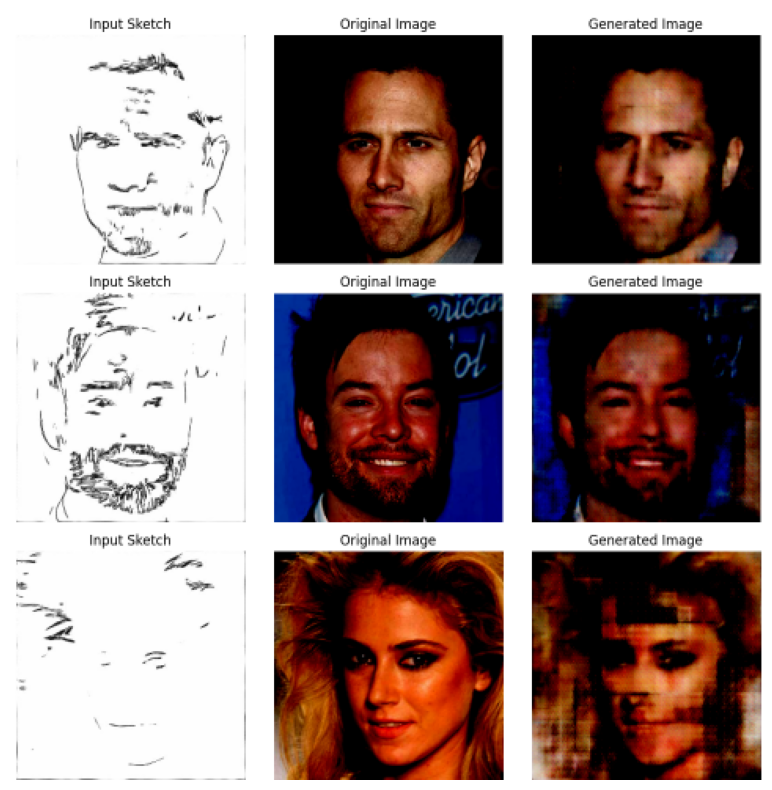

In [7]:
# Visualization
sample_idxs = np.random.randint(0, X_train.shape[0], 3)
sketches = X_train[sample_idxs]
reals = Y_train[sample_idxs]
fakes = gen.predict(sketches)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
titles = ["Sketch", "Real", "Generated"]

for i in range(3):
    axs[i, 0].imshow(sketches[i].squeeze(), cmap='gray')
    axs[i, 1].imshow((reals[i] + 1) / 2)
    axs[i, 2].imshow((fakes[i] + 1) / 2)
    for j in range(3):
        axs[i, j].axis('off')
        axs[0, j].set_title(titles[j])
plt.tight_layout()
plt.show()
